In [1]:
%load_ext Cython

In [3]:
!pip install keras 

In [4]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
csv = './openpowerlifting-2020-09-06.csv'
df = pandas.read_csv(csv,index_col=0,low_memory=False)
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0, 'Mx': -1})
df['Equipment'] = df['Equipment'].map({'Single-ply':0, 'Raw':1, 'Wraps':2, 'Unlimited':3, 'Multi-ply':4})
data = df[['Sex','BodyweightKg', 'Best3SquatKg', 'Best3DeadliftKg', 'Best3BenchKg','Age','Country','Equipment']].dropna(how='any')
x_train, x_test, y_train, y_test  = train_test_split(
    data.drop(['Best3BenchKg', 'Country', 'Equipment'], axis = 1).astype('float'),
    data['Best3BenchKg'].astype('float')
)
x_train = x_train.to_numpy()
x_test= x_test.to_numpy()
y_train= y_train.to_numpy()
y_test = y_test.to_numpy()

In [11]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer().fit(x_train)
x_train = normalizer.transform(x_train) 
x_test = normalizer.transform(x_test)

In [12]:
%%cython
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
71602/71602 [==============================] - 161s 2ms/step - loss: 17748.4169 - mean_squared_error: 17748.4169 - rmse: 122.2082 - r_square: -111.0483 - val_loss: 17747.7031 - val_mean_squared_error: 17747.7031 - val_rmse: 122.2331 - val_r_square: -9936328.0000
Epoch 2/15
71602/71602 [==============================] - 160s 2ms/step - loss: 17772.1356 - mean_squared_error: 17772.1356 - rmse: 122.2433 - r_square: -102.0537 - val_loss: 17747.7031 - val_mean_squared_error: 17747.7031 - val_rmse: 122.2331 - val_r_square: -9936328.0000
Epoch 3/15
71602/71602 [==============================] - 158s 2ms/step - loss: 17790.3692 - mean_squared_

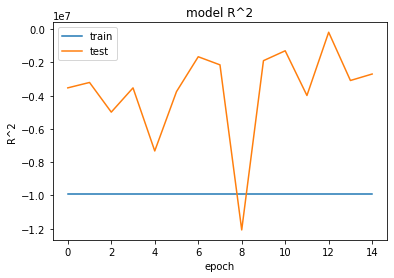

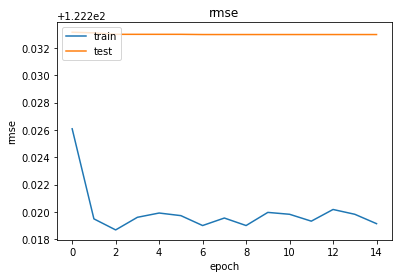

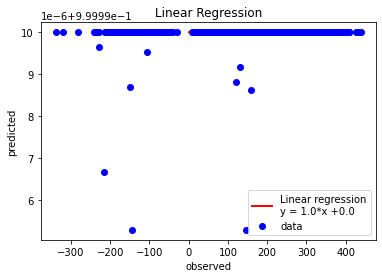



Mean absolute error (MAE):      122.232960
Mean squared error (MSE):       17747.700114
Root mean squared error (RMSE): 133.220494
R square (R^2):                 -5.159675


In [13]:
model = Sequential()
# model.add(Dense(64, activation='sigmoid'))
# model.add(Dense(64, activation='sigmoid', input_dim=x_train.shape[1]))
model.add(Dense(1, activation='sigmoid', input_dim=x_train.shape[1]))
model.summary()
optimizer = optimizers.SGD(learning_rate=0.1)
# SGD 最急降下法にランダム性
# Adam 後で使う
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error", rmse, r_square])
earlystopping=EarlyStopping(monitor="rmse", patience=40, verbose=1, mode='auto')
# fit model
result = model.fit(x_train, y_train, epochs=15, batch_size=5, validation_data=(x_test, y_test), callbacks=[earlystopping])
y_pred = model.predict(x_test)

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(result.history['val_r_square'])
plt.plot(result.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(y_test.reshape(-1,1), y_pred)  
y_fit = regressor.predict(y_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

plt.scatter(y_test, y_pred, color='blue', label= 'data')
plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

#-----------------------------------------------------------------------------
# print statistical figures of merit
#-----------------------------------------------------------------------------

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y_test,y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test,y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y_test,y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test,y_pred))